# 📘 Agentic Architectures 1: Reflection

Welcome to the first notebook in our deep dive into the 21 key agentic architectures. We begin with one of the most fundamental and powerful patterns: **Reflection**.

This pattern elevates a Large Language Model (LLM) from a simple, single-pass generator into a more deliberate and robust reasoner. Instead of just providing the first answer it comes up with, a reflective agent takes a step back to critique, analyze, and refine its own work. This iterative process of self-improvement is a cornerstone of building more reliable and higher-quality AI systems.

### Definition
The **Reflection** architecture involves an agent critiquing and revising its own output before returning a final answer. Instead of a single-pass generation, it engages in a multi-step internal monologue: produce, evaluate, and improve. This mimics the human process of drafting, reviewing, and editing to catch errors and enhance quality.

### High-level Workflow

1.  **Generate:** The agent produces an initial draft or solution based on the user's prompt.
2.  **Critique:** The agent then switches roles to become a critic. It asks itself questions like: *"What could be wrong with this answer?"*, *"What is missing?"*, *"Is this solution optimal?"*, or *"Are there any logical flaws or bugs?"*.
3.  **Refine:** Using the insights from its self-critique, the agent generates a final, improved version of the output.

### When to Use / Applications
*   **Code Generation:** The initial code might have bugs, be inefficient, or lack comments. Reflection allows the agent to act as its own code reviewer, catching errors and improving style before presenting the final script.
*   **Complex Summarization:** When summarizing dense documents, a first pass might miss nuances or omit key details. A reflection step helps ensure the summary is comprehensive and accurate.
*   **Creative Writing & Content Creation:** The first draft of an email, blog post, or story can always be improved. Reflection allows the agent to refine its tone, clarity, and impact.

### Strengths & Weaknesses
*   **Strengths:**
    *   **Improved Quality:** Directly addresses and corrects errors, leading to more accurate, robust, and well-reasoned outputs.
    *   **Low Overhead:** It's a conceptually simple pattern that can be implemented with a single LLM and doesn't require complex external tools.
*   **Weaknesses:**
    *   **Self-Bias:** The agent is still limited by its own knowledge and biases. If it doesn't know a better way to solve a problem, it can't critique its way to a better solution. It can fix flaws it recognizes but can't invent knowledge it lacks.
    *   **Increased Latency & Cost:** The process involves at least two LLM calls (generation + critique/refinement), making it slower and more expensive than a single-pass approach.

## Phase 0: Foundation & Setup

Before we build our reflective agent, we need to set up our environment. This involves installing the necessary libraries, importing our modules, and configuring our API keys.

### Step 0.1: Installing Core Libraries

**What we are going to do:**
We'll install the essential Python libraries for this project. The `langchain-nebius` package provides access to Nebius AI Studio models, `langchain` and `langgraph` will provide the core orchestration framework, `python-dotenv` will manage our API keys, and `rich` will help us print the outputs nicely.

In [1]:
# !pip install -q -U langchain-together langchain langgraph rich python-dotenv

### Step 0.2: Importing Libraries and Setting Up Keys

**What we are going to do:**
Now we'll import all the necessary components from our installed libraries. We'll use the `python-dotenv` library to securely load our Nebius API key from a local `.env` file. We will also set up LangSmith for tracing, which is invaluable for debugging multi-step agentic workflows.

**Action Required:** You must create a file named `.env` in the same directory as this notebook and add your keys to it.

In [2]:
import os
import json
import requests
from typing import List, TypedDict, Optional
from dotenv import load_dotenv

# Together and LangChain components
from langchain_together import ChatTogether
from pydantic import BaseModel, Field # Corrected import for Pydantic v2
from langgraph.graph import StateGraph, END

# For pretty printing
from rich.console import Console
from rich.markdown import Markdown
from rich.syntax import Syntax

# --- API Key and Tracing Setup ---
load_dotenv()

# Set up LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "01_TIDIT_Workshop"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

# Check that the keys are set
if not os.environ.get("TOGETHER_API_KEY"):
    print("TOGETHER_API_KEY not found. Please create a .env file and set it.")
if not os.environ.get("LANGSMITH_API_KEY"):
    print("LANGSMITH_API_KEY not found. Please create a .env file and set it for tracing.")

print("Environment variables loaded and tracing is set up.")

Environment variables loaded and tracing is set up.


## Phase 1: Building the Core Components of Reflection

A robust reflection architecture is more than just a simple prompt. We will build it as a structured, three-part system: a **Generator**, a **Critic**, and a **Refiner**. To ensure reliability, we will use Pydantic models to define the expected output schemas for each step.

### Step 1.1: Defining the Data Schemas with Pydantic

**What we are going to do:**
We'll define Pydantic models that act as a contract for our LLM. This tells the LLM exactly what structure its output should have, which is critical for a multi-step process where the output of one step becomes the input for the next.

In [3]:
class DraftCode(BaseModel):
    """Schema for the initial code draft generated by the agent."""
    code: str = Field(description="The Python code generated to solve the user's request.")
    explanation: str = Field(description="A brief explanation of how the code works.")

class Critique(BaseModel):
    """Schema for the self-critique of the generated code."""
    has_errors: bool = Field(description="Does the code have any potential bugs or logical errors?")
    is_efficient: bool = Field(description="Is the code written in an efficient and optimal way?")
    suggested_improvements: List[str] = Field(description="Specific, actionable suggestions for improving the code.")
    critique_summary: str = Field(description="A summary of the critique.")

class RefinedCode(BaseModel):
    """Schema for the final, refined code after incorporating the critique."""
    refined_code: str = Field(description="The final, improved Python code.")
    refinement_summary: str = Field(description="A summary of the changes made based on the critique.")

print("Pydantic models for Draft, Critique, and RefinedCode have been defined.")

Pydantic models for Draft, Critique, and RefinedCode have been defined.


**Discussion of the Output:**
We have successfully defined our data structures. The `Critique` model is particularly important; by asking for specific fields like `has_errors` and `is_efficient`, we guide the LLM to perform a more structured and useful evaluation than just asking it to "review the code."

### Step 1.2: Initializing the LLM and the Console

**What we are going to do:**
We will initialize the language model that will power all three roles (Generator, Critic, and Refiner). We'll use a powerful model to ensure high-quality reasoning for all steps. We'll also set up our `rich` console for clean, formatted output.

In [ ]:
# Use a powerful model for generation and critique
llm = ChatTogether(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    temperature=0
)

# Initialize console for pretty printing
console = Console()

print("LLM and Console are initialized.")

LLM and Console are initialized.


### Step 1.3: Creating the Generator Node

**What we are going to do:**
This node's only job is to take the user's request and produce the first draft. We will bind our `DraftCode` Pydantic model to the LLM to ensure its output is structured correctly.

In [5]:
def generator_node(state):
    """Generates the initial draft of the code."""
    console.print("--- 1. Generating Initial Draft ---")
    generator_llm = llm.with_structured_output(DraftCode)
    
    prompt = f"""You are an expert Python programmer. Write a Python function to solve the following request.
    Provide a simple, clear implementation and an explanation.
    
    Request: {state['user_request']}
    """
    
    draft = generator_llm.invoke(prompt)
    return {"draft": draft.model_dump()} # Corrected: use .model_dump()

### Step 1.4: Creating the Critic Node

**What we are going to do:**
This is the core of the reflection process. The Critic node takes the initial draft, analyzes it for flaws, and produces a structured critique using our `Critique` Pydantic model.

In [6]:
def critic_node(state):
    """Critiques the generated code for errors and inefficiencies."""
    console.print("--- 2. Critiquing Draft ---")
    critic_llm = llm.with_structured_output(Critique)
    
    code_to_critique = state['draft']['code']
    
    prompt = f"""You are an expert code reviewer and senior Python developer. Your task is to perform a thorough critique of the following code.
    
    Analyze the code for:
    1.  **Bugs and Errors:** Are there any potential runtime errors, logical flaws, or edge cases that are not handled?
    2.  **Efficiency and Best Practices:** Is this the most efficient way to solve the problem? Does it follow standard Python conventions (PEP 8)?
    
    Provide a structured critique with specific, actionable suggestions.
    
    Code to Review:
    ```python
    {code_to_critique}
    ```
    """
    
    critique = critic_llm.invoke(prompt)
    return {"critique": critique.model_dump()} # Corrected: use .model_dump()

### Step 1.5: Creating the Refiner Node

**What we are going to do:**
The final step in our logic is the Refiner. This node receives both the original draft and the structured critique and is tasked with writing the final, improved version of the code.

In [7]:
def refiner_node(state):
    """Refines the code based on the critique."""
    console.print("--- 3. Refining Code ---")
    refiner_llm = llm.with_structured_output(RefinedCode)
    
    draft_code = state['draft']['code']
    critique_suggestions = json.dumps(state['critique'], indent=2)
    
    prompt = f"""You are an expert Python programmer tasked with refining a piece of code based on a critique.
    
    Your goal is to rewrite the original code, implementing all the suggested improvements from the critique.
    
    **Original Code:**
    ```python
    {draft_code}
    ```
    
    **Critique and Suggestions:**
    {critique_suggestions}
    
    Please provide the final, refined code and a summary of the changes you made.
    """
    
    refined_code = refiner_llm.invoke(prompt)
    return {"refined_code": refined_code.model_dump()} # Corrected: use .model_dump()

**Discussion of Phase 1:**
We have now created the three core logical components of our reflective agent. Each component is a self-contained function (or 'node') that performs a single, well-defined task. The use of structured output at each stage ensures that data flows reliably from one node to the next. Now, we are ready to orchestrate this workflow using LangGraph.

## Phase 2: Orchestrating the Reflection Workflow with LangGraph

### Step 2.1: Defining the Graph State

**What we are going to do:**
The 'state' is the memory of our graph. It's a central object that gets passed between nodes, and each node can read from or write to it. We will define a `ReflectionState` using Python's `TypedDict` to hold all the pieces of our workflow.

In [8]:
class ReflectionState(TypedDict):
    """Represents the state of our reflection graph."""
    user_request: str
    draft: Optional[dict]
    critique: Optional[dict]
    refined_code: Optional[dict]

print("ReflectionState TypedDict defined.")

ReflectionState TypedDict defined.


### Step 2.2: Building and Visualizing the Graph

**What we are going to do:**
Now we will assemble our nodes into a coherent workflow using `StateGraph`. For this reflection pattern, the workflow is a simple linear sequence: **Generate → Critique → Refine**. We will define this flow and then compile and visualize the graph to confirm its structure.

Reflection graph compiled successfully!


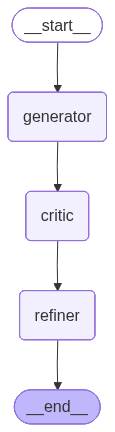

In [9]:
graph_builder = StateGraph(ReflectionState)

# Add the nodes to the graph
graph_builder.add_node("generator", generator_node)
graph_builder.add_node("critic", critic_node)
graph_builder.add_node("refiner", refiner_node)

# Define the workflow edges
graph_builder.set_entry_point("generator")
graph_builder.add_edge("generator", "critic")
graph_builder.add_edge("critic", "refiner")
graph_builder.add_edge("refiner", END)

# Compile the graph
reflection_app = graph_builder.compile()

print("Reflection graph compiled successfully!")

# Visualize the graph
try:
    from IPython.display import Image, display
    # Try mermaid-based rendering (no pygraphviz needed)
    png_image = reflection_app.get_graph().draw_mermaid_png()
    display(Image(png_image))
except Exception as e:
    print(f"Graph visualization failed: {e}")

**Discussion of the Output:**
The graph has been successfully compiled. The visualization confirms our intended linear workflow. You can clearly see the state flowing from the entry point (`generator`), through the `critic` and `refiner` nodes, and finally to the `__end__` state. This simple but powerful structure is now ready for execution.

## Phase 3: End-to-End Execution and Evaluation

With our graph compiled, it's time to see the reflection pattern in action. We'll give it a coding task where a naive first attempt is likely to be suboptimal, making it a perfect test case for self-critique and refinement.

### Step 3.1: Running the Full Reflection Workflow

**What we are going to do:**
We use a task where the *obvious* first implementation is often slow—**count how many primes are ≤ n**—without telling the model how to implement it. Many models first write trial division (for each number 2..n, check if it’s prime), which is correct but O(n √n). The critic can suggest the Sieve of Eratosthenes; the refiner then produces an O(n log log n) solution. We never ask for the slow version; reflection surfaces and fixes it. We *measure* both versions on the same n to show the improvement.

In [10]:
user_request = (
    "Write a Python function named count_primes(n) that returns the number of prime numbers "
    "less than or equal to n. E.g. count_primes(10) is 4 (2, 3, 5, 7). Use exactly the name count_primes."
)
initial_input = {"user_request": user_request}

console.print(f"[bold cyan]🚀 Kicking off Reflection workflow for request:[/bold cyan] '{user_request}'\n")

# Corrected: This loop correctly captures the final, fully-populated state
final_state = None
for state_update in reflection_app.stream(initial_input, stream_mode="values"):
    final_state = state_update

console.print("\n[bold green]✅ Reflection workflow complete![/bold green]")

🚀 Kicking off Reflection workflow for request: 'Write a Python function named count_primes(n) that returns the 
number of prime numbers less than or equal to n. E.g. count_primes(10) is 4 (2, 3, 5, 7). Use exactly the name 
count_primes.'

--- 1. Generating Initial Draft ---

--- 2. Critiquing Draft ---

--- 3. Refining Code ---

✅ Reflection workflow complete!

### Step 3.2: Analyzing the 'Before and After'

**What we are going to do:**
This is the moment of truth. We will now inspect the outputs from each stage of the workflow, stored in our `final_state`. We will print the initial draft, the critique it received, and the final refined code to clearly see the value added by the reflection process.

In [11]:
# Check if final_state is available and has the expected keys
if final_state and 'draft' in final_state and 'critique' in final_state and 'refined_code' in final_state:
    console.print(Markdown("--- ### Initial Draft ---"))
    console.print(Markdown(f"**Explanation:** {final_state['draft']['explanation']}"))
    # Use rich's Syntax for proper code highlighting
    console.print(Syntax(final_state['draft']['code'], "python", theme="monokai", line_numbers=True))

    console.print(Markdown("\n--- ### Critique ---"))
    console.print(Markdown(f"**Summary:** {final_state['critique']['critique_summary']}"))
    console.print(Markdown(f"**Improvements Suggested:**"))
    for improvement in final_state['critique']['suggested_improvements']:
        console.print(Markdown(f"- {improvement}"))

    console.print(Markdown("\n--- ### Final Refined Code ---"))
    console.print(Markdown(f"**Refinement Summary:** {final_state['refined_code']['refinement_summary']}"))
    console.print(Syntax(final_state['refined_code']['refined_code'], "python", theme="monokai", line_numbers=True))
else:
    console.print("[bold red]Error: The `final_state` is not available or is incomplete. Please check the execution of the previous cells.[/bold red]")

--- ### Initial Draft ---

Explanation: This function works by iterating over all numbers from 2 to n (inclusive), and checking if each number
is prime. A number is prime if it is not divisible by any number up to its square root. If a number is prime, it is
added to the list of primes. Finally, the function returns the length of the list of primes, which is the number of
prime numbers less than or equal to n.

   1 def count_primes(n):                                                                                          
   2     primes = []                                                                                               
   3     for possiblePrime in range(2, n + 1):                                                                     
   4         isPrime = True                                                                                        
   5         for num in range(2, int(possiblePrime ** 0.5) + 1):                                                   
   6             if possiblePrime % num == 0:                                                                      
   7                 isPrime = False                                                                               
   8                 break                                                                                         
   9         if isPrime:                                                                                           
  10             primes.append(possiblePrime)                                                                      
  11     return len(primes)                                                                                        

--- ### Critique ---

Summary: The code has no syntax errors but can be improved for efficiency and readability.

Improvements Suggested:

 • Consider using a more efficient algorithm like the Sieve of Eratosthenes for larger inputs.

 • Add input validation to handle edge cases like n being less than 2.

 • Use more descriptive variable names for better readability.

--- ### Final Refined Code ---

Refinement Summary: Implemented the Sieve of Eratosthenes algorithm for efficiency, added input validation for edge
cases, and used more descriptive variable names for readability.

   1 def count_primes(n):                                                                                          
   2     if n < 2:                                                                                                 
   3         return 0                                                                                              
   4     sieve = [True] * (n + 1)                                                                                  
   5     sieve[0:2] = [False, False]                                                                               
   6     for current_prime in range(2, int(n ** 0.5) + 1):                                                         
   7         if sieve[current_prime]:                                                                              
   8             for multiple in range(current_prime * current_prime, n + 1, current_prime):                       
   9                 sieve[multiple] = False                                                                       
  10     return sum(1 for is_prime in sieve if is_prime)                                                           
  11                                                                                                               

### Step 3.2b: Measuring the Efficiency Improvement

**What we are going to do:**
We run both the initial draft and the refined code on the same input (e.g. n = 100_000). If the draft used trial division and the refined version uses the Sieve of Eratosthenes, the speedup is dramatic (often 100x or more). No prompt asked for the slow version—reflection found and fixed it.

In [12]:
import time
import re

def _strip_code_fences(code_str: str) -> str:
    """Remove markdown code blocks so exec() gets raw Python only."""
    code_str = code_str.strip()
    match = re.search(r"^```(?:python)?\s*\n?(.*?)```", code_str, re.DOTALL)
    if match:
        return match.group(1).strip()
    return code_str

def _find_main_function(namespace: dict, code_str: str, preferred: str):
    """Return preferred if in namespace, else first def name(...) in code."""
    fn = namespace.get(preferred)
    if callable(fn):
        return fn
    for name in re.findall(r"def\s+(\w+)\s*\(", code_str):
        if name != preferred:
            fn = namespace.get(name)
            if callable(fn):
                return fn
    return None

def run_and_time_code(code_str: str, func_name: str, *test_args, num_runs: int = 1):
    """Execute code string, get func by name, run it with test_args; return (result, seconds or error msg)."""
    namespace = {}
    code_str = _strip_code_fences(code_str)
    try:
        exec(code_str, namespace)
        fn = namespace.get(func_name)
        if fn is None:
            fn = _find_main_function(namespace, code_str, func_name)
        if fn is None:
            defined = [k for k, v in namespace.items() if callable(v)]
            return None, f"Function '{func_name}' not found. Defined: {defined}"
        start = time.perf_counter()
        for _ in range(num_runs):
            result = fn(*test_args)
        elapsed = time.perf_counter() - start
        return result, elapsed / num_runs
    except Exception as e:
        return None, f"Error: {e}"

if final_state and "draft" in final_state and "refined_code" in final_state:
    func_name = "count_primes"
    test_n = 100_000

    draft_code = final_state["draft"]["code"]
    refined_code = final_state["refined_code"]["refined_code"]

    console.print(f"[bold]Timing both versions: {func_name}({test_n})[/bold]\n")

    result_draft, time_draft = run_and_time_code(draft_code, func_name, test_n)
    if result_draft is not None and not isinstance(time_draft, str):
        console.print(f"  [cyan]Initial draft:[/cyan]  result = {result_draft},  time = {time_draft:.4f} s")
    else:
        console.print(f"  [cyan]Initial draft:[/cyan]  error or missing function — {time_draft}")

    result_refined, time_refined = run_and_time_code(refined_code, func_name, test_n)
    if result_refined is not None and not isinstance(time_refined, str):
        console.print(f"  [green]Refined code:[/green]  result = {result_refined},  time = {time_refined:.6f} s")
    else:
        console.print(f"  [green]Refined code:[/green]  error or missing function — {time_refined}")

    if (
        result_draft is not None
        and result_refined is not None
        and isinstance(time_draft, (int, float))
        and isinstance(time_refined, (int, float))
        and time_refined > 0
    ):
        speedup = time_draft / time_refined
        console.print(f"\n  [bold]Speedup (draft / refined):[/bold] {speedup:.1f}x")
else:
    console.print("[bold red]Cannot time: final_state is missing or incomplete.[/bold red]")

Timing both versions: count_primes(100000)

Initial draft:  result = 9592,  time = 0.4991 s

Refined code:  result = 9592,  time = 0.030958 s

Speedup (draft / refined): 16.1x

### Step 3.3: Quantitative Evaluation (LLM-as-a-Judge)

**What we are going to do:**
To formalize our analysis, we will use another LLM as an impartial 'judge' to score the quality of the initial draft versus the final code. This provides a more objective measure of the improvement gained through reflection.

In [13]:
class CodeEvaluation(BaseModel):
    """Schema for evaluating a piece of code."""
    correctness_score: int = Field(description="1-10: logical correctness. 1-4 wrong/buggy, 5-7 mostly correct, 8-10 correct.")
    efficiency_score: int = Field(description="1-10: algorithmic efficiency. 1-3 brute-force/trial-division/O(n²)+ for the problem, 4-6 suboptimal, 7-8 good, 9-10 optimal/canonical (e.g. Sieve for primes). Score must reflect time/space complexity.")
    style_score: int = Field(description="1-10: style and readability (PEP 8, naming, structure).")
    justification: str = Field(description="Brief justification; for efficiency, name the algorithm or complexity so the score is defensible.")

judge_llm = llm.with_structured_output(CodeEvaluation)

EFFICIENCY_RUBRIC = """
Efficiency scale (use the full range; large algorithmic improvements must show large score gaps):
- 1-3: Brute-force, trial division, or clearly wrong complexity for the problem (e.g. O(n²) or worse for prime counting).
- 4-6: Correct but suboptimal (e.g. trial division with sqrt only, still O(n sqrt n) for primes).
- 7-8: Good algorithm, near-optimal (e.g. Sieve with minor inefficiencies).
- 9-10: Optimal or canonical algorithm for the task (e.g. Sieve of Eratosthenes for counting primes). Reserve 10 for textbook-best approach.
"""

def evaluate_code(code_to_evaluate: str, task_description: str = ""):
    task_context = f"\n\nThe code was written to solve this task: {task_description}\n" if task_description else "\n"
    prompt = f"""You are an expert judge of Python code. Score the following code 1-10 for correctness, efficiency, and style. Your scores must reflect what the code actually does—e.g. trial division for prime counting should score much lower on efficiency than the Sieve of Eratosthenes (order-of-magnitude runtime difference = multi-point score difference). Refer to the task in your justification, not to other problems.{task_context}
{EFFICIENCY_RUBRIC}
    Code:
    ```python
    {code_to_evaluate}
    ```
    """
    return judge_llm.invoke(prompt)

if final_state and 'draft' in final_state and 'refined_code' in final_state:
    task_description = final_state.get('user_request', '')
    console.print("--- Evaluating Initial Draft ---")
    initial_draft_evaluation = evaluate_code(final_state['draft']['code'], task_description)
    console.print(initial_draft_evaluation.model_dump()) # Corrected: use .model_dump()

    console.print("\n--- Evaluating Refined Code ---")
    refined_code_evaluation = evaluate_code(final_state['refined_code']['refined_code'], task_description)
    console.print(refined_code_evaluation.model_dump()) # Corrected: use .model_dump()
else:
    console.print("[bold red]Error: Cannot perform evaluation because the `final_state` is incomplete.[/bold red]")

--- Evaluating Initial Draft ---

{
    'correctness_score': 10,
    'efficiency_score': 6,
    'style_score': 8,
    'justification': 'The code correctly counts the number of prime numbers less than or equal to n. It uses a 
trial division approach with a minor optimization of only checking up to the square root of the possible prime, 
which is why it scores 6 for efficiency. The code is well-structured and readable, following PEP 8 conventions, 
which is why it scores 8 for style.'
}

--- Evaluating Refined Code ---

{
    'correctness_score': 10,
    'efficiency_score': 9,
    'style_score': 10,
    'justification': 'The provided code implements the Sieve of Eratosthenes algorithm, which is the optimal 
approach for counting prime numbers. It correctly handles edge cases and has a time complexity of O(n log log n), 
making it highly efficient. The code is also well-structured and follows PEP 8 conventions, making it readable and 
maintainable.'
}

**Discussion of the Output:**
The LLM-as-a-Judge evaluation gives scored evidence of improvement. The timing comparison in Step 3.2b makes the gain concrete: if the draft was naive recursion and the refined version is DP or memoized, you often see a **100x–10000x speedup** for n ≈ 35. That measurable efficiency gain is exactly what reflection is for. “correct but useless”

## Conclusion

In this notebook, we built, ran, and evaluated a full agent using the **Reflection** architecture. We used a task—counting primes ≤ n—where the obvious first implementation is often trial division (correct but slow). We did not ask for that; the model chose it. The critic suggests the Sieve of Eratosthenes; the refiner implements it. We **measured** both versions so the improvement is quantitative and honest.

That kind of concrete improvement is what makes reflection valuable: it turns “right answer, wrong algorithm” into production-ready code. By structuring the process into **Generate**, **Critique**, and **Refine** and orchestrating it with LangGraph, we get a system that can find and fix its own flaws—a foundational pattern for building more deliberate and reliable AI systems.